# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Class')

Mounted at /content/drive


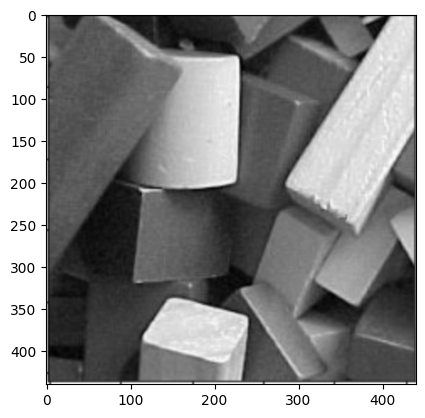

image.shape:  (440, 440)


In [2]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("blocks.jpg",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)


## Step 1. Gaussian filter

original shape(440, 440)
gaussian shape(440, 440)


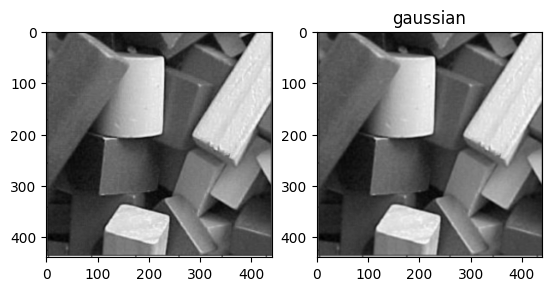

In [3]:
def padding_img(img,k_size,style='edge'):
  # ------------ To do ------------- #
  w,h=img.shape
  p_image=np.zeros((w+k_size*2,h+k_size*2)).astype('uint8')
  p_image[k_size:-k_size,k_size:-k_size]+=img

  return p_image

def gaussian_kernel(size):
  # ------------ To do ------------- #
  sigma = 0.3*((KernelSize-1)*0.5 - 1) + 0.8
  Gaussian=[]
  #各係數相加後總值
  total=0
  for i in range(0,KernelSize):
      Filter_list = []
      for j in range(0,KernelSize):
          #高斯函數公式
          # -------------- To do ----------------- #
          center=KernelSize//2
          k=-((i-center)**2+(j-center)**2)/(2*sigma**2)
          a=1/(2*math.pi*sigma**2)
          G=a*math.e**(k)
          total+=G
          Filter_list.append(G)
      Gaussian+= [Filter_list]
  #print(Gaussia)
  return np.array(Gaussian)/total
KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    # ------------ To do ------------- #
    center=KernelSize//2
    # for i in range(row):
    #   for j in range(col):
    #     for u in range(-(KernelSize-1)//2,(KernelSize-1)//2+1):
    #       for v in range(-(KernelSize-1)//2,(KernelSize-1)//2+1):
    #         resx[i][j]+=Gaussian_Kernel[center+u][center+v]*padimg[i+u][j+v]
    for i in range(0,row):
      for j in range(0,col):
        resx[i,j]=np.sum(np.multiply(Gaussian_Kernel,padimg[i:i+KernelSize,j:j+KernelSize]))
    resx=np.clip(resx,0,255).astype('uint8')
    return resx
gaussian=Gaussian_Filter(KernelSize,img_org)
print(f'original shape{img_org.shape}')
print(f'gaussian shape{gaussian.shape}')
plt.subplot(121)
plt.imshow(img_org,cmap='gray')
plt.subplot(122)
plt.title('original')
plt.imshow(gaussian,cmap='gray')
plt.title("gaussian")
plt.show()

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [6]:

def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    Gx = np.zeros((h-2, w-2))
    Gy = np.zeros((h-2, w-2))

    # ------------ To do ------------- #
    regions=iterate_regions(img,3)
    for window,i,j in regions:
      Gx[i,j]=np.sum(np.multiply(horizontal,window))
      Gy[i,j]=np.sum(np.multiply(vertical,window))
    # print(Gx)
    amplitude=np.clip(np.sqrt(Gx**2+Gy**2),0,255).astype('uint8')
    angle=np.arctan2(Gy,Gx)*180/math.pi
    Gx=np.clip(np.absolute(Gx),0,255).astype('uint8')
    Gy=np.clip(np.absolute(Gy),0,255).astype('uint8')
    output=[Gx,Gy,amplitude]
    return output, angle


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j



gaussian shape:(440, 440)
Horizontal Sobel filter shape:(440, 440)
Vertical Sobel filter shape:(440, 440)
Gradient amplitude shape:(440, 440)


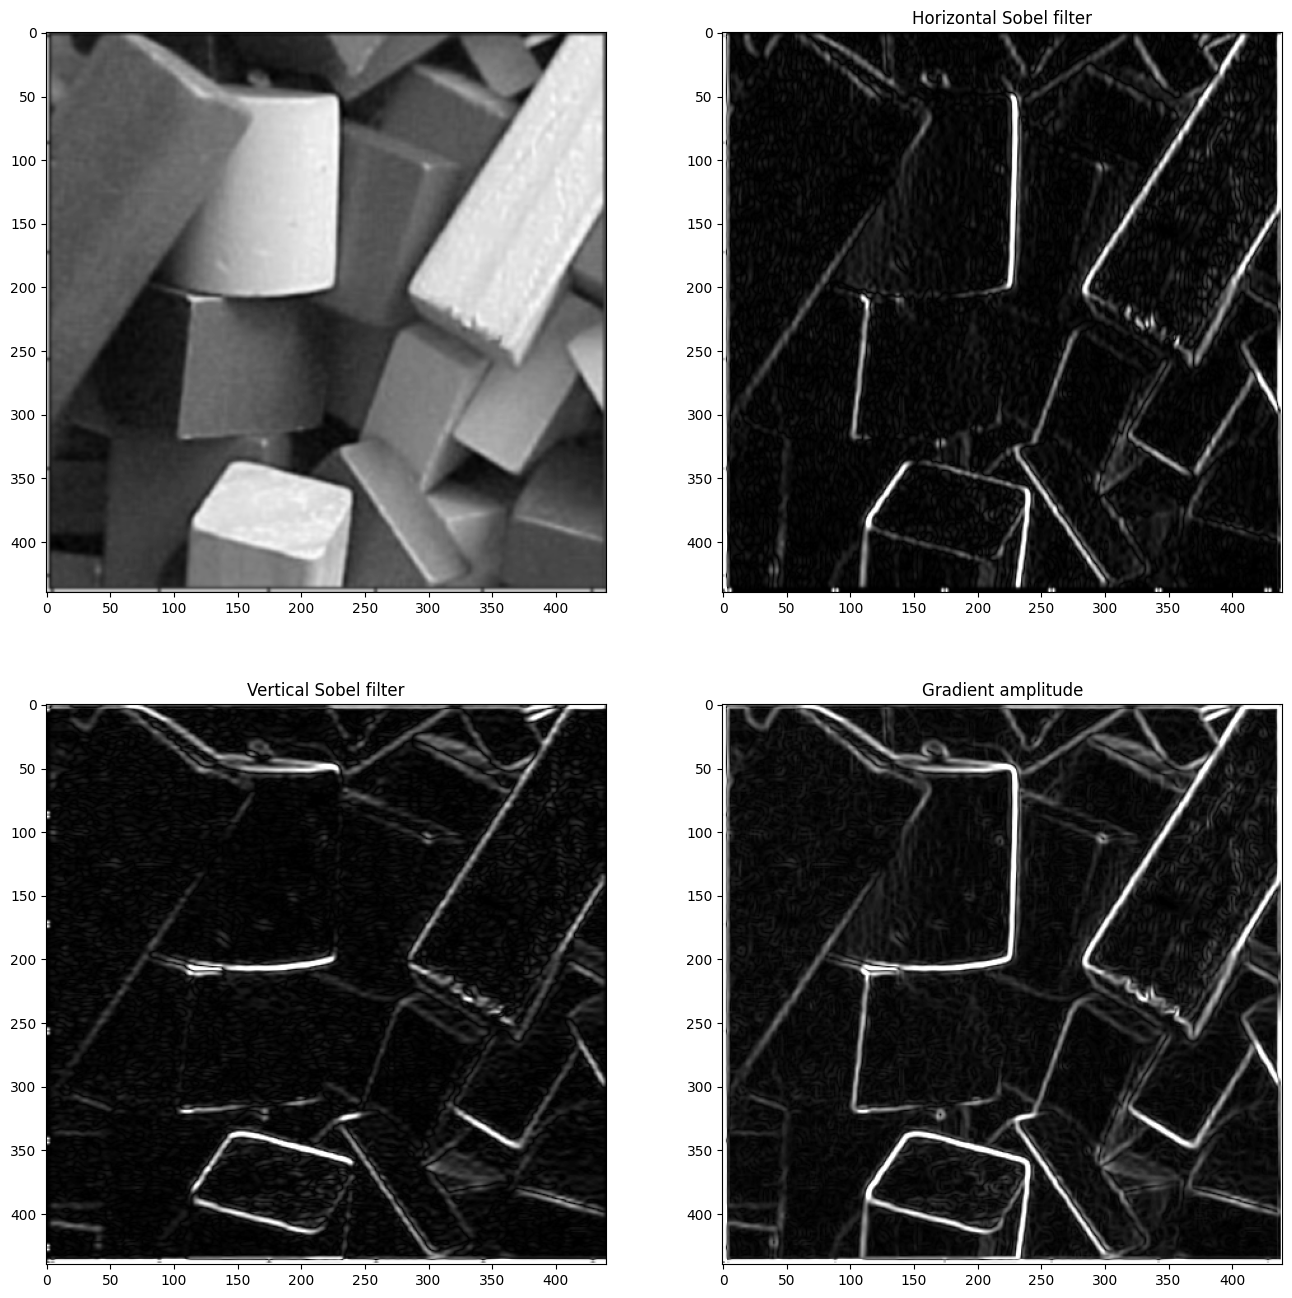

In [9]:
# ------------ To do ------------- #
gaussian_pad=padding_img(gaussian,1)
output,angle=sobel(gaussian_pad,"magnitude")
print(f'gaussian shape:{gaussian.shape}')
print(f'Horizontal Sobel filter shape:{output[0].shape}')
print(f'Vertical Sobel filter shape:{output[1].shape}')
print(f'Gradient amplitude shape:{output[2].shape}')
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(gaussian,cmap='gray')
plt.subplot(222)
plt.title('original')
plt.imshow(output[0],cmap='gray')
plt.title("Horizontal Sobel filter")
plt.subplot(223)
plt.imshow(output[1],cmap='gray')
plt.title("Vertical Sobel filter")
plt.subplot(224)
plt.imshow(output[2],cmap='gray')
plt.title("Gradient amplitude")
plt.show()

## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [10]:

def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            # ------------ To do ------------- #
          if(angle[i,j]>=-22.5 and angle[i,j]<=22.5)or(angle[i,j]<-157.5 and angle[i,j]>=-180):#or(angle[i,j]>157.5 and angle[i,j]<=180):
            if(gradient_copy[i][j]<gradient[i][j+1] or gradient_copy[i][j]<gradient[i][j-1]):
              gradient_copy[i][j]=0
          elif(angle[i,j]>=22.5 and angle[i,j]<=67.5)or(angle[i,j]<-112.5 and angle[i,j]>=-157.5):
            if(gradient_copy[i][j]<gradient[i+1][j+1] or gradient_copy[i][j]<gradient[i-1][j-1]):
              gradient_copy[i][j]=0
          elif (angle[i,j]>=67.5 and angle[i,j]<=112.5)or(angle[i,j]<-67.5 and angle[i,j]>=-112.5):
            if(gradient_copy[i][j]<gradient[i-1][j] or gradient_copy[i][j]<gradient[i+1][j]):
              gradient_copy[i][j]=0
          elif (angle[i,j]>=112.5 and angle[i,j]<=157.5)or(angle[i,j]<-22.5 and angle[i,j]>=-67.5):
            if(gradient_copy[i][j]<gradient[i-1][j-1] or gradient_copy[i][j]<gradient[i+1][j+1]):
              gradient_copy[i][j]=0

    return gradient_copy

gradient,angle = sobel(img_org, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient[2],angle)
print(angle)

[[-135.46112308 -143.97262661 -106.28492247 ...  102.43186063
   137.55109509   93.0127875 ]
 [-141.76310546 -160.70995378   37.07307332 ...  103.57043439
   133.70458757  127.6656212 ]
 [ 139.73343833  149.30555185   24.97391091 ...  134.65063982
   165.48138999  165.8276623 ]
 ...
 [ 173.15044201  166.85215216  145.75096699 ...   99.9580706
   121.34235749   45.        ]
 [ 155.50266407  140.45681844  125.46566805 ...   91.92842231
    95.76602277   80.78397732]
 [ 135.          128.72270151  136.45944935 ...   90.92703527
    92.59039835   85.92083617]]


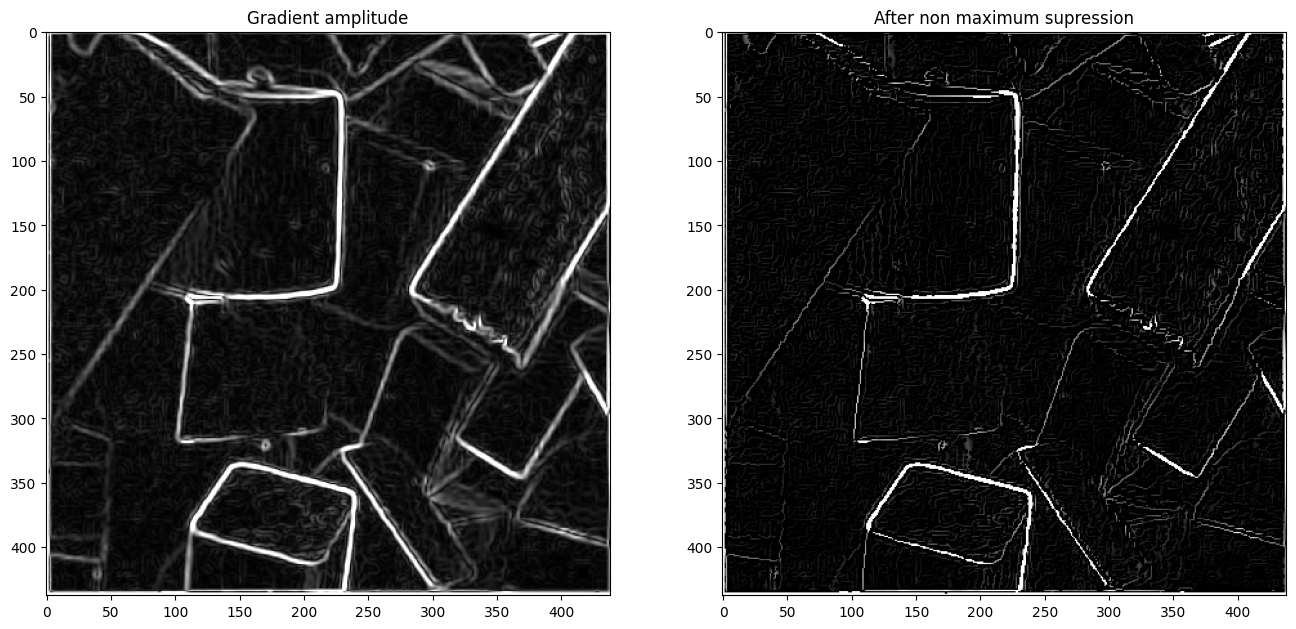

In [11]:
# ------------ To do ------------- #
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(gradient[2],cmap='gray')
plt.title("Gradient amplitude")
plt.subplot(122)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title("After non maximum supression")
plt.show()

## Step 4. Thresholding edges

In [12]:
def seperate(img, minimum = 60, maximum = 180):
    # ------------ To do ------------- #
  w,h=img.shape
  threshold=img.copy()
  for i in range(w):
    for j in range(h):
      if(img[i,j]<=minimum):
        threshold[i,j]=0
      elif img[i,j]>minimum and img[i,j]<maximum:
        threshold[i,j]=minimum
      elif img[i,j]>=maximum:
        threshold[i,j]=255
  return threshold
thresholding = seperate(After_non_maximum_supression, minimum = 15, maximum = 90)

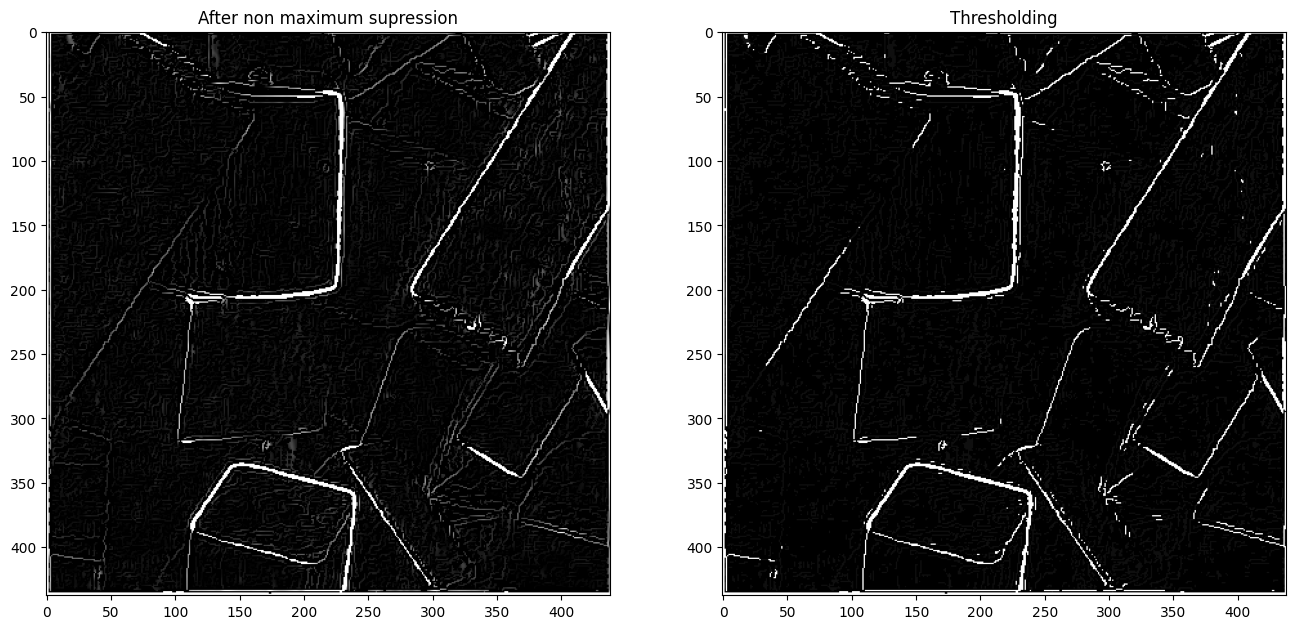

In [13]:
# ------------ To do ------------- #
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title("After non maximum supression")
plt.subplot(122)
plt.imshow(thresholding,cmap='gray')
plt.title("Thresholding")
plt.show()

## Step 5. Hysteresis

In [15]:
def Connect(img,weak=60):
  # ------------ To do ------------- #
  w,h=img.shape
  output=img.copy()
  for i in range(w-1):
    for j in range(h-1):
      if (img[i,j] == weak):
        if ((img[i+1,j-1]>weak) or (img[i+1,j]>weak) or (img[i+1,j+1]>weak)
          or (img[i,j-1]>weak) or (img[i,j+1]>weak)
          or (img[i-1,j-1]>weak) or (img[i-1,j]>weak) or (img[i-1,j+1]>weak)):
            output[i,j]=255
        else:
            output[i,j] = 0
  return output
weak=15
dst_img = Connect(thresholding,weak)


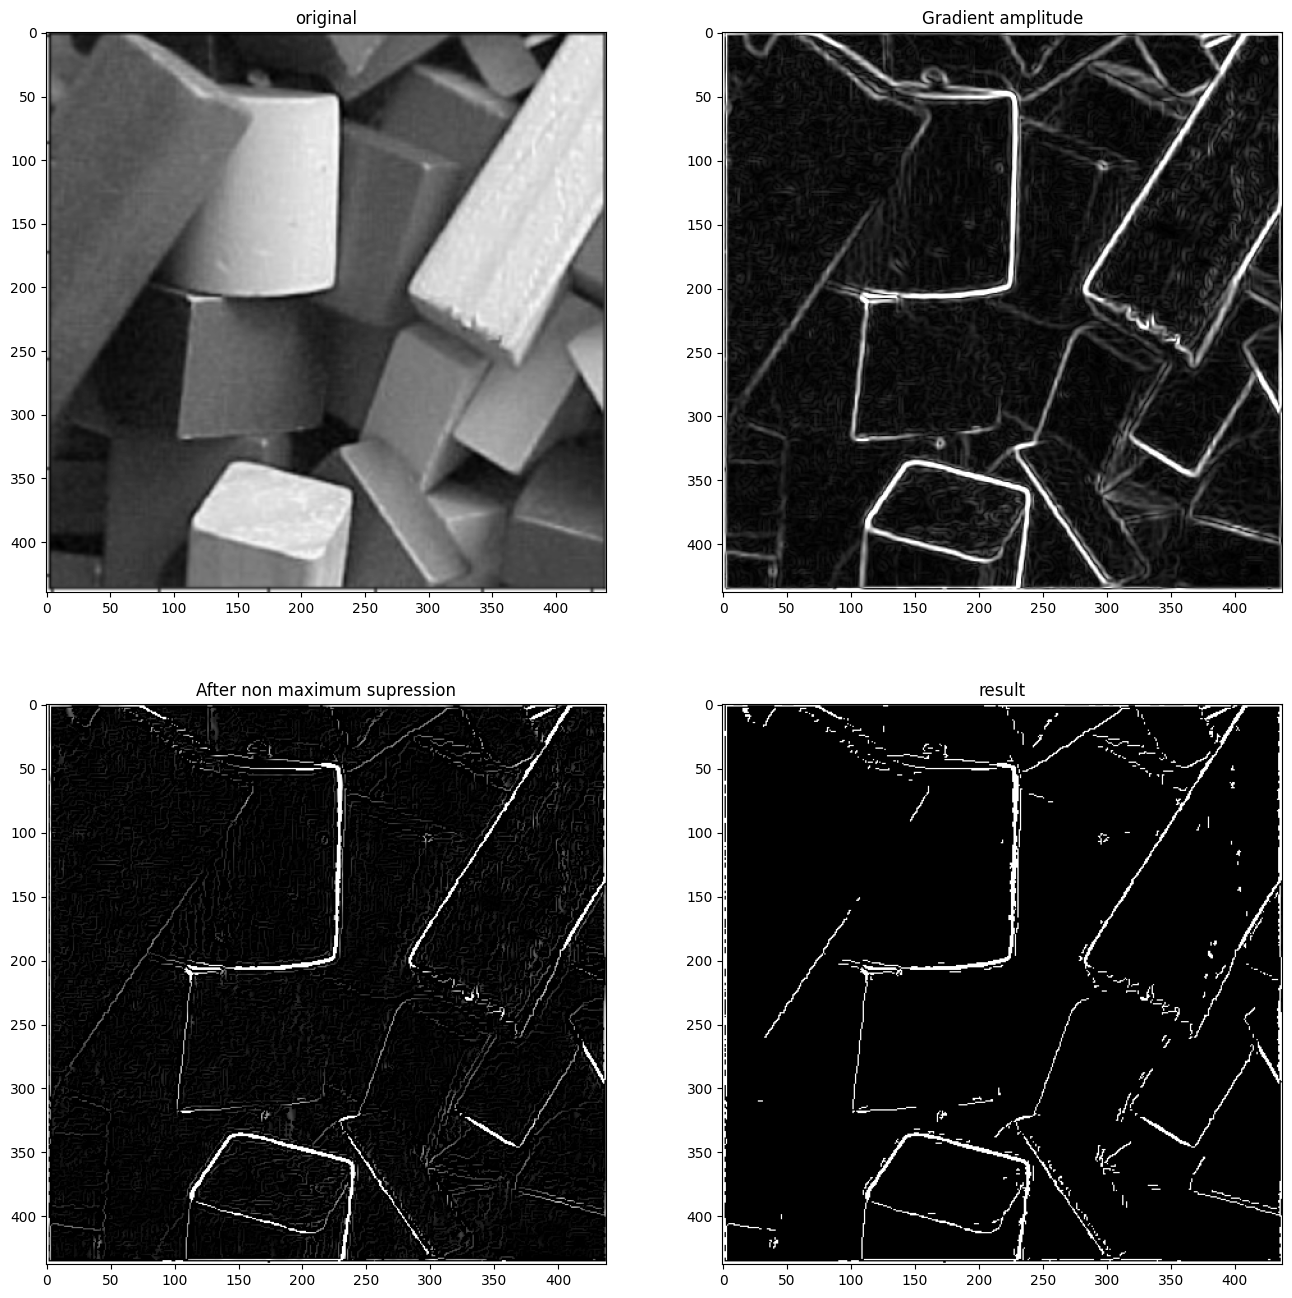

In [16]:
# ------------ To do ------------- #
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(img_org,cmap='gray')
plt.title('original')
plt.subplot(222)
plt.imshow(gradient[2],cmap='gray')
plt.title("Gradient amplitude")
plt.subplot(223)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title("After non maximum supression")
plt.subplot(224)
plt.imshow(dst_img,cmap='gray')
plt.title("result")
plt.show()

## Canny Edge OpenCV 套件


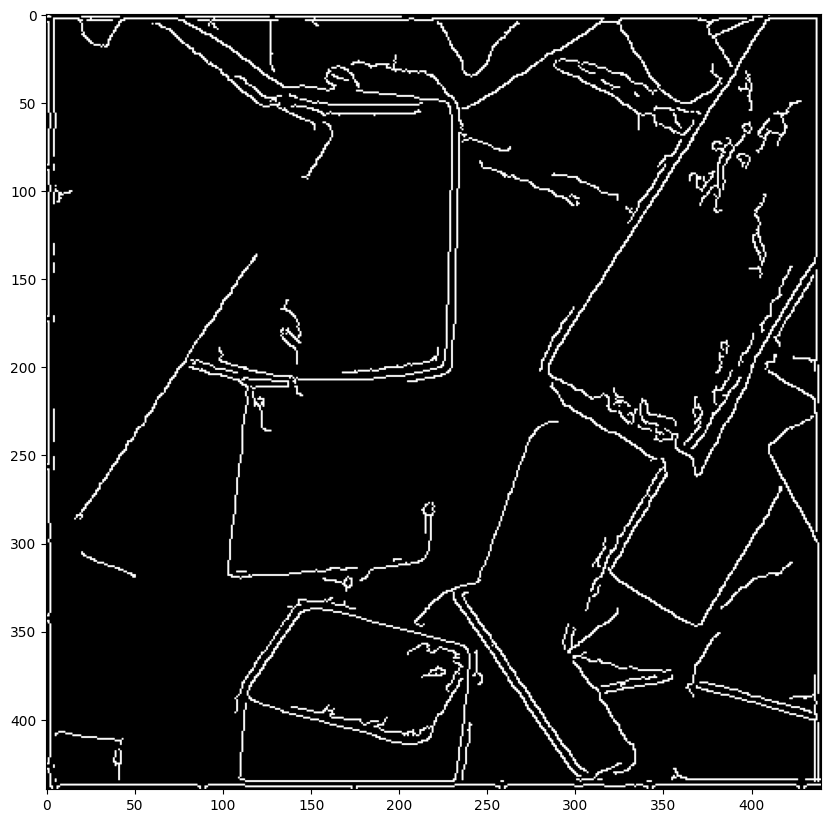

In [17]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("blocks.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

## 加分討論：為什麼和套件不一樣？

因為...

# 加分題目 : Dilation (膨脹) & Erosion (侵蝕)

## Dilation (膨脹)

In [ ]:
def Dilation(img, kernel):
  row, col = img.shape
  dilation_img = np.zeros((row, col))
  kernelsize = kernel.shape[0]
  img = padding_img(img, (kernelsize-1)//2, channel = 1)

  # -------- To do ------------- #

  # ------------------------------- #
  return dilation_img

res = Dilation(image, get_kernel('dilation', kernel_size = 3))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('dilation')
plt.imshow(res, cmap = 'gray')
plt.show()

print('original shape: ', image.shape)
print('dilation shape: ', res.shape)

## Erosion (侵蝕)

In [ ]:
def Erosion(img, kernel):
  row, col = img.shape
  erosion_img = np.zeros((row, col))
  kernelsize = kernel.shape[0]
  img = padding_img(img, (kernelsize-1)//2, channel = 1)

  # -------- To do ------------- #

  # ------------------------------- #
  return erosion_img

res = Erosion(image, get_kernel('erosion', kernel_size = 3))

plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title('original')
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.title('erosion')
plt.imshow(res, cmap = 'gray')
plt.show()

print('original shape: ', image.shape)
print('erosion shape: ', res.shape)